In [5]:
from os import listdir
import keras
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img 

In [ ]:
path = '/content/drive/My Drive/Pix2pix/maps/train/'

src_list, tar_list = list(), list()
for filename in listdir(path):
  if (filename.endswith(".jpg")):
    pixels = load_img(path + filename, target_size=(256,512))
    pixels = img_to_array(pixels)
    sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
src_images = asarray(src_list)
tar_images = asarray(tar_list)

print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
from matplotlib import pyplot

In [ ]:
src_images = (src_images - 127.5) / 127.5
tar_images = (tar_images - 127.5) / 127.5

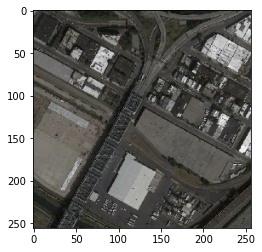

In [ ]:
temp = (src_images[0]+1)/2.0
pyplot.imshow(temp)

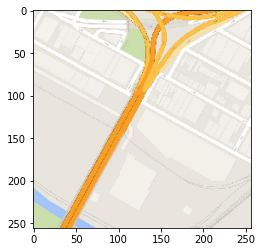

In [ ]:
temp = (tar_images[0] + 1) / 2.0
pyplot.imshow(temp)

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
# weight initialization
init = RandomNormal(stddev=0.02)
# source image input
in_src_image = Input(shape=(256,256,3))
# target image input
in_target_image = Input(shape=(256,256,3))
# concatenate images channel-wise
merged = Concatenate()([in_src_image, in_target_image])
# C64
d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
d = LeakyReLU(alpha=0.2)(d)
# C128
d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# C256
d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# C512
d = keras.layers.ZeroPadding2D()(d)

d = Conv2D(512, (4,4), strides=(1,1), kernel_initializer=init)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# second last output layer
d = keras.layers.ZeroPadding2D()(d)
out_patch = keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(d)

discriminator = Model([in_src_image, in_target_image], out_patch)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
# to make learning og D slow we have 0.5 weight on loss
discriminator.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[1])

In [ ]:
# define the standalone 
init = RandomNormal(stddev=0.02)
# image input
in_image = Input(shape=(256,256,3))
# encoder model
e1 = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
e1 = LeakyReLU(alpha=0.2)(e1)

e2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e1)
e2 = BatchNormalization()(e2, training=True)
e2 = LeakyReLU(alpha=0.2)(e2)

e3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e2)
e3 = BatchNormalization()(e3, training=True)
e3 = LeakyReLU(alpha=0.2)(e3)


e4 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e3)
e4 = BatchNormalization()(e4, training=True)
e4 = LeakyReLU(alpha=0.2)(e4)


e5 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e4)
e5 = BatchNormalization()(e5, training=True)
e5 = LeakyReLU(alpha=0.2)(e5)


e6 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
e6 = BatchNormalization()(e6, training=True)
e6 = LeakyReLU(alpha=0.2)(e6)


e7 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
e7 = BatchNormalization()(e7, training=True)
e7 = LeakyReLU(alpha=0.2)(e7)


e8 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
e8 = BatchNormalization()(e8, training=True)
e8 = LeakyReLU(alpha=0.2)(e8)


temp = Model(in_image, e8)

In [ ]:

# decoder model
d1 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e8)
# add batch normalization
d1 = BatchNormalization()(d1, training=True)
d1 = Dropout(0.5)(d1, training=True)
# merge with skip connection
d1 = Concatenate()([d1, e7])
# relu activation
d1 = Activation('relu')(d1)


d2 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d1)
# add batch normalization
d2 = BatchNormalization()(d2, training=True)
d2 = Dropout(0.5)(d2, training=True)
# merge with skip connection
d2 = Concatenate()([d2, e6])
# relu activation
d2 = Activation('relu')(d2)


d3 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d2)
# add batch normalization
d3 = BatchNormalization()(d3, training=True)
d3 = Dropout(0.5)(d3, training=True)
# merge with skip connection
d3 = Concatenate()([d3, e5])
# relu activation
d3 = Activation('relu')(d3)


d4 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d3)
# add batch normalization
d4 = BatchNormalization()(d4, training=True)
# merge with skip connection
d4 = Concatenate()([d4, e4])
# relu activation
d4 = Activation('relu')(d4)


d5 = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)
# add batch normalization
d5 = BatchNormalization()(d5, training=True)
# merge with skip connection
d5 = Concatenate()([d5, e3])
# relu activation
d5 = Activation('relu')(d5)


d6 = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d5)
# add batch normalization
d6 = BatchNormalization()(d6, training=True)
# merge with skip connection
d6 = Concatenate()([d6, e2])
# relu activation
d6 = Activation('relu')(d6)


d7 = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
# add batch normalization
d7 = BatchNormalization()(d7, training=True)
# merge with skip connection
d7 = Concatenate()([d7, e1])
# relu activation
d7 = Activation('relu')(d7)

# output
g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
out_image = Activation('tanh')(g)
# define model
generator = Model(in_image, out_image)

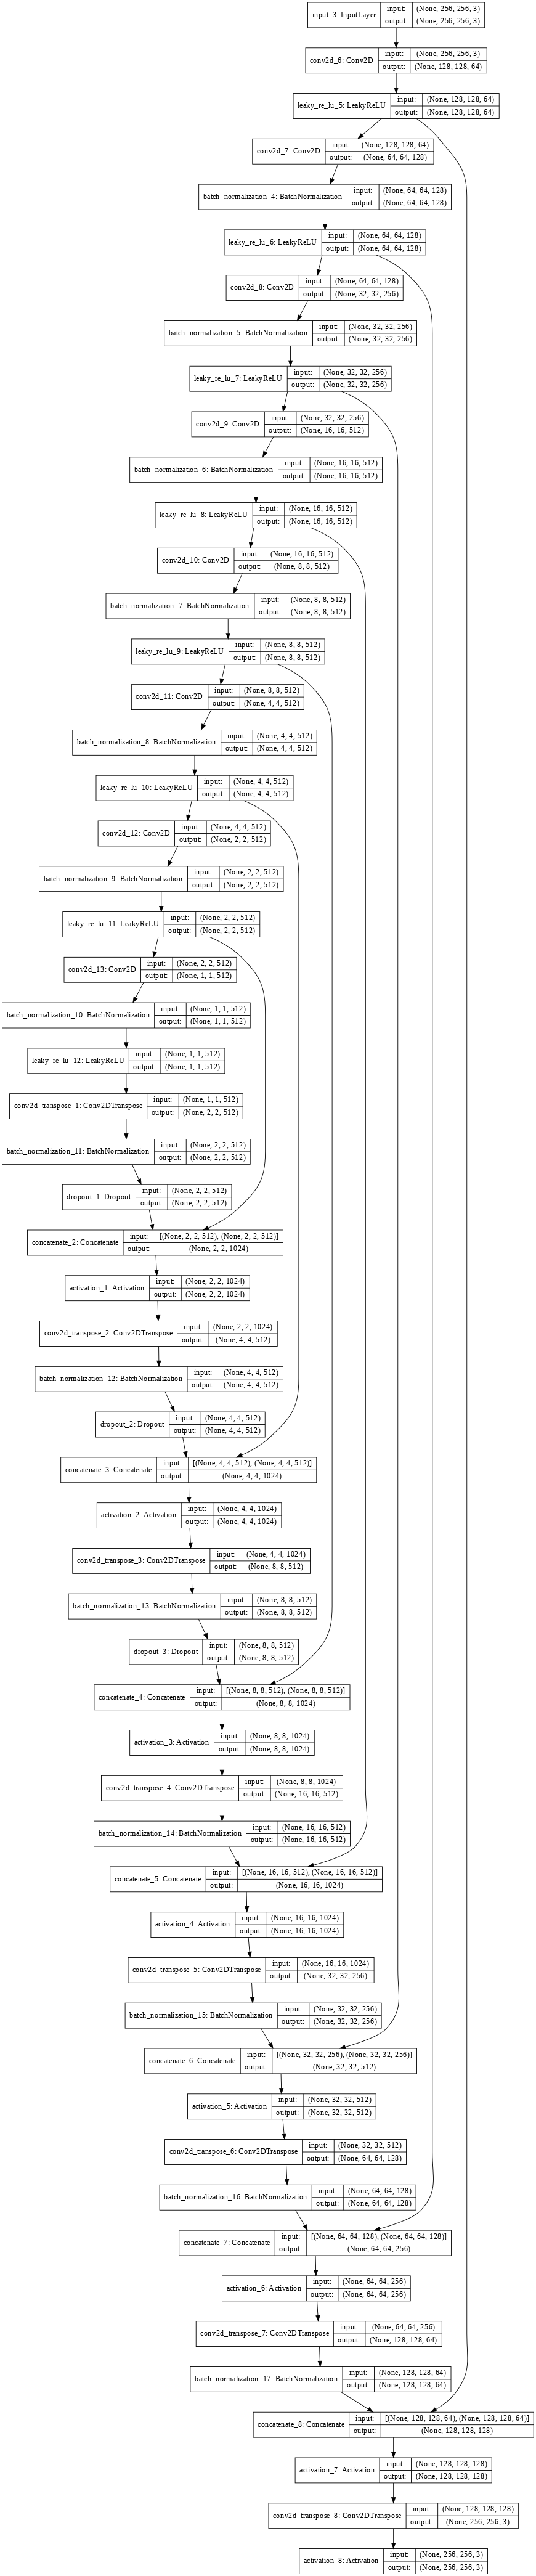

In [ ]:
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

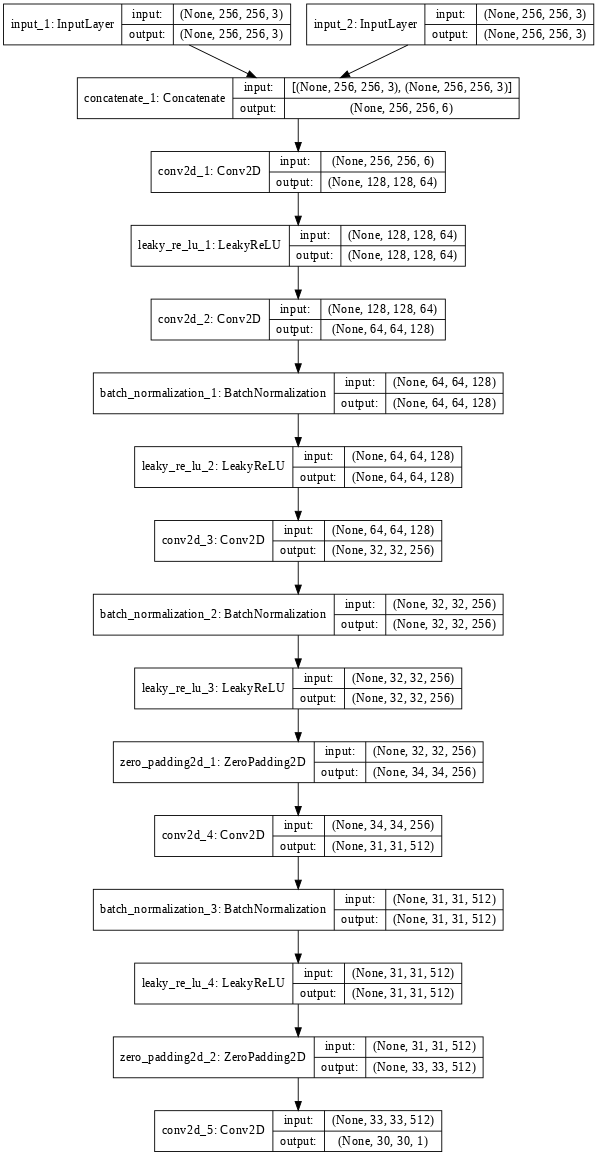

In [ ]:
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
discriminator.trainable = False
# define the source image
in_src = Input(shape=(256,256,3))
# connect the source image to the generator input
gen_out = generator(in_src)
# connect the source input and generator output to the discriminator input
dis_out = discriminator([in_src, gen_out])
# src image as input, generated image and classification output
gan = Model(in_src, [dis_out, gen_out])
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
gan.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])

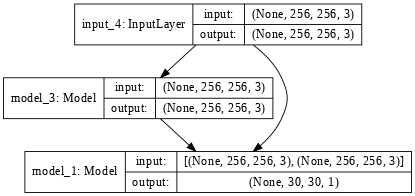

In [ ]:
keras.utils.plot_model(gan, show_shapes=True, dpi=64)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model.predict(test_input)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

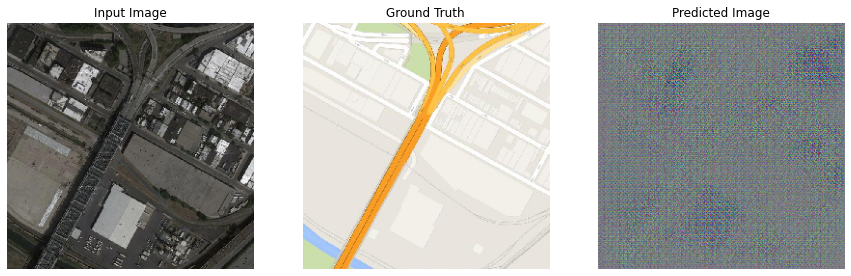

In [ ]:
generate_images(generator, np.expand_dims(src_images[0],axis=0), np.expand_dims(tar_images[0],axis=0))

>1, 1/34, d1=5.717, d2=9.190 g=18.660
>1, 2/34, d1=5.688, d2=9.111 g=13.944
>1, 3/34, d1=6.477, d2=8.742 g=21.442
>1, 4/34, d1=3.458, d2=10.597 g=13.956
>1, 5/34, d1=6.785, d2=8.533 g=23.895
>1, 6/34, d1=5.366, d2=9.645 g=12.692
>1, 7/34, d1=4.851, d2=10.875 g=14.960
>1, 8/34, d1=4.826, d2=10.153 g=16.035
>1, 9/34, d1=3.113, d2=11.371 g=19.706
>1, 10/34, d1=7.142, d2=7.735 g=15.555
>1, 11/34, d1=6.299, d2=8.905 g=19.837
>1, 12/34, d1=6.337, d2=8.942 g=19.235
>1, 13/34, d1=5.748, d2=9.176 g=11.433
>1, 14/34, d1=7.040, d2=8.949 g=10.962
>1, 15/34, d1=5.401, d2=8.954 g=12.324
>1, 16/34, d1=6.057, d2=9.424 g=12.427
>1, 17/34, d1=4.985, d2=9.915 g=15.346
>1, 18/34, d1=5.322, d2=9.433 g=13.531
>1, 19/34, d1=4.128, d2=10.128 g=17.582
>1, 20/34, d1=7.065, d2=8.511 g=14.358
>1, 21/34, d1=5.900, d2=8.990 g=12.192
>1, 22/34, d1=5.014, d2=10.274 g=12.357
>1, 23/34, d1=3.166, d2=10.583 g=14.925
>1, 24/34, d1=5.804, d2=8.904 g=15.390
>1, 25/34, d1=4.472, d2=9.723 g=14.857
>1, 26/34, d1=5.663, d2=9.2

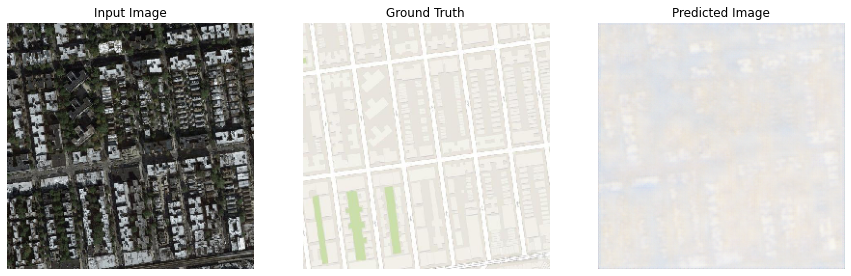

>2, 1/34, d1=3.153, d2=11.327 g=12.289
>2, 2/34, d1=2.535, d2=11.654 g=12.362
>2, 3/34, d1=2.900, d2=11.774 g=20.015
>2, 4/34, d1=2.786, d2=11.412 g=13.778
>2, 5/34, d1=2.028, d2=12.186 g=12.779
>2, 6/34, d1=2.615, d2=11.831 g=15.634
>2, 7/34, d1=3.426, d2=11.082 g=11.074
>2, 8/34, d1=2.441, d2=12.099 g=9.945
>2, 9/34, d1=3.036, d2=11.477 g=9.529
>2, 10/34, d1=2.837, d2=12.517 g=12.917
>2, 11/34, d1=3.872, d2=10.934 g=11.483
>2, 12/34, d1=2.731, d2=11.489 g=14.425
>2, 13/34, d1=3.017, d2=11.413 g=14.427
>2, 14/34, d1=3.702, d2=11.272 g=17.511
>2, 15/34, d1=2.520, d2=11.584 g=13.183
>2, 16/34, d1=3.103, d2=11.645 g=11.823
>2, 17/34, d1=1.238, d2=12.627 g=17.727
>2, 18/34, d1=2.964, d2=11.439 g=14.030
>2, 19/34, d1=3.959, d2=11.524 g=10.792
>2, 20/34, d1=2.622, d2=12.148 g=10.283
>2, 21/34, d1=4.053, d2=10.989 g=12.394
>2, 22/34, d1=1.938, d2=12.092 g=15.361
>2, 23/34, d1=2.794, d2=11.224 g=18.767
>2, 24/34, d1=2.963, d2=11.168 g=12.422
>2, 25/34, d1=2.926, d2=11.202 g=18.507
>2, 26/34, 

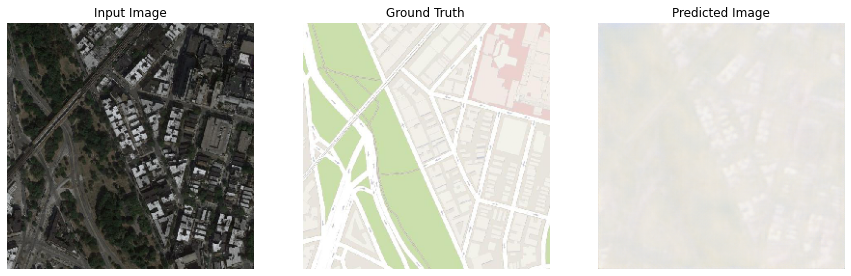

>3, 1/34, d1=2.310, d2=12.296 g=11.751
>3, 2/34, d1=2.006, d2=12.060 g=11.394
>3, 3/34, d1=1.282, d2=11.881 g=14.036
>3, 4/34, d1=1.183, d2=12.758 g=8.501
>3, 5/34, d1=1.495, d2=12.413 g=6.986
>3, 6/34, d1=0.934, d2=12.427 g=10.700
>3, 7/34, d1=1.897, d2=12.164 g=9.531
>3, 8/34, d1=1.876, d2=12.142 g=13.216
>3, 9/34, d1=2.063, d2=11.969 g=11.900
>3, 10/34, d1=1.519, d2=11.646 g=18.297
>3, 11/34, d1=2.514, d2=11.754 g=11.096
>3, 12/34, d1=1.831, d2=11.992 g=7.631
>3, 13/34, d1=0.071, d2=13.574 g=12.959
>3, 14/34, d1=1.692, d2=12.017 g=7.835
>3, 15/34, d1=1.786, d2=11.973 g=13.786
>3, 16/34, d1=2.277, d2=12.070 g=13.724
>3, 17/34, d1=4.131, d2=9.150 g=16.130
>3, 18/34, d1=4.180, d2=9.298 g=8.574
>3, 19/34, d1=5.542, d2=8.930 g=12.322
>3, 20/34, d1=5.605, d2=9.844 g=12.277
>3, 21/34, d1=5.816, d2=8.901 g=14.466
>3, 22/34, d1=4.832, d2=9.749 g=19.760
>3, 23/34, d1=4.362, d2=9.089 g=16.163
>3, 24/34, d1=4.951, d2=9.612 g=15.882
>3, 25/34, d1=4.555, d2=9.723 g=12.000
>3, 26/34, d1=4.651, d2=

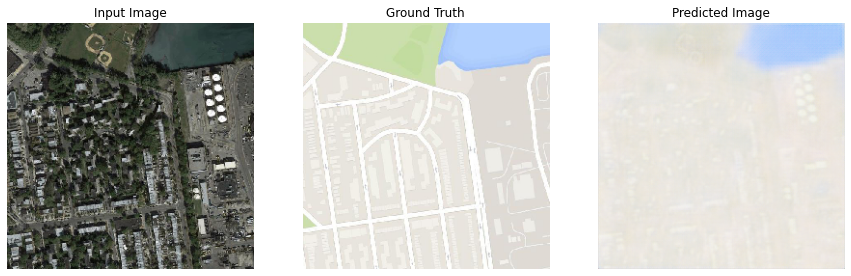

>4, 1/34, d1=0.017, d2=13.786 g=7.829
>4, 2/34, d1=0.018, d2=13.756 g=8.183
>4, 3/34, d1=-0.000, d2=13.800 g=8.884
>4, 4/34, d1=0.017, d2=13.800 g=8.030
>4, 5/34, d1=-0.000, d2=13.800 g=5.600
>4, 6/34, d1=-0.000, d2=13.800 g=10.219
>4, 7/34, d1=-0.000, d2=13.800 g=8.759
>4, 8/34, d1=0.000, d2=13.786 g=10.032
>4, 9/34, d1=-0.000, d2=13.800 g=20.298
>4, 10/34, d1=-0.000, d2=13.800 g=9.618
>4, 11/34, d1=-0.000, d2=13.800 g=9.403
>4, 12/34, d1=-0.000, d2=13.786 g=10.744
>4, 13/34, d1=-0.000, d2=13.800 g=14.121
>4, 14/34, d1=-0.000, d2=13.800 g=7.737
>4, 15/34, d1=-0.000, d2=13.786 g=14.380
>4, 16/34, d1=0.154, d2=13.705 g=7.248
>4, 17/34, d1=0.034, d2=13.732 g=10.518
>4, 18/34, d1=-0.000, d2=13.800 g=7.523
>4, 19/34, d1=-0.000, d2=13.800 g=8.835
>4, 20/34, d1=-0.000, d2=13.800 g=6.718
>4, 21/34, d1=-0.000, d2=13.771 g=13.709
>4, 22/34, d1=-0.000, d2=13.800 g=7.751
>4, 23/34, d1=0.000, d2=13.773 g=12.767
>4, 24/34, d1=0.000, d2=13.786 g=12.750
>4, 25/34, d1=0.017, d2=13.772 g=8.322
>4, 26/3

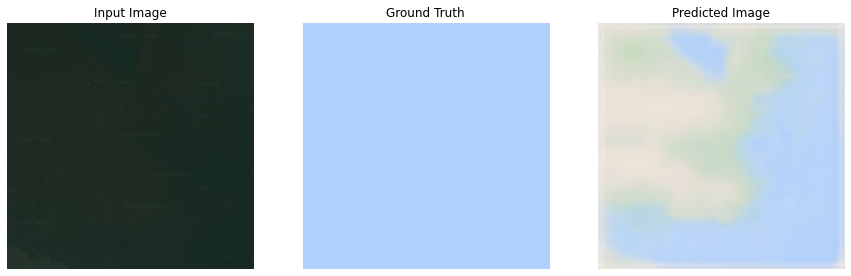

>5, 1/34, d1=0.017, d2=13.786 g=8.384
>5, 2/34, d1=-0.000, d2=13.800 g=6.925
>5, 3/34, d1=0.034, d2=13.758 g=11.537
>5, 4/34, d1=0.017, d2=13.786 g=7.275
>5, 5/34, d1=0.004, d2=13.744 g=9.651
>5, 6/34, d1=-0.000, d2=13.800 g=8.447
>5, 7/34, d1=-0.000, d2=13.800 g=10.602
>5, 8/34, d1=0.018, d2=13.745 g=5.585
>5, 9/34, d1=0.052, d2=13.800 g=6.371
>5, 10/34, d1=-0.000, d2=13.800 g=8.256
>5, 11/34, d1=0.036, d2=13.730 g=11.296
>5, 12/34, d1=-0.000, d2=13.800 g=6.250
>5, 13/34, d1=0.000, d2=13.800 g=14.476
>5, 14/34, d1=-0.000, d2=13.800 g=5.633
>5, 15/34, d1=-0.000, d2=13.800 g=7.107
>5, 16/34, d1=-0.000, d2=13.800 g=9.080
>5, 17/34, d1=-0.000, d2=13.800 g=6.401
>5, 18/34, d1=-0.000, d2=13.800 g=12.412
>5, 19/34, d1=-0.000, d2=13.772 g=7.834
>5, 20/34, d1=0.000, d2=13.772 g=9.730
>5, 21/34, d1=-0.000, d2=13.800 g=10.868
>5, 22/34, d1=-0.000, d2=13.800 g=10.390
>5, 23/34, d1=-0.000, d2=13.800 g=10.625
>5, 24/34, d1=-0.000, d2=13.800 g=9.132
>5, 25/34, d1=-0.000, d2=13.800 g=13.224
>5, 26/34

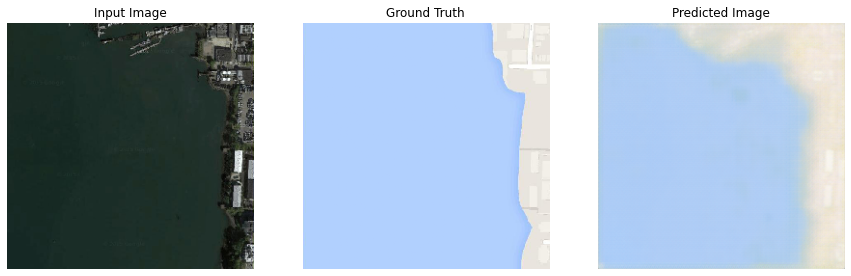

>6, 1/34, d1=7.024, d2=8.126 g=14.297
>6, 2/34, d1=9.492, d2=6.805 g=13.640
>6, 3/34, d1=6.386, d2=8.817 g=16.363
>6, 4/34, d1=7.250, d2=6.152 g=19.221
>6, 5/34, d1=6.564, d2=8.526 g=14.004
>6, 6/34, d1=6.279, d2=8.657 g=15.734
>6, 7/34, d1=12.588, d2=6.206 g=15.053
>6, 8/34, d1=6.079, d2=8.222 g=17.930
>6, 9/34, d1=8.954, d2=7.499 g=17.160
>6, 10/34, d1=6.912, d2=7.660 g=14.975
>6, 11/34, d1=6.340, d2=8.667 g=16.956
>6, 12/34, d1=7.698, d2=7.808 g=15.309
>6, 13/34, d1=6.623, d2=8.007 g=23.068
>6, 14/34, d1=11.151, d2=4.898 g=17.889
>6, 15/34, d1=8.351, d2=7.788 g=15.696
>6, 16/34, d1=9.343, d2=7.612 g=13.921
>6, 17/34, d1=8.356, d2=7.398 g=16.456
>6, 18/34, d1=7.835, d2=7.739 g=18.630
>6, 19/34, d1=6.314, d2=8.572 g=18.609
>6, 20/34, d1=6.588, d2=8.403 g=18.721
>6, 21/34, d1=7.656, d2=7.749 g=19.593
>6, 22/34, d1=6.458, d2=9.300 g=17.066
>6, 23/34, d1=8.514, d2=8.101 g=16.457
>6, 24/34, d1=7.601, d2=7.746 g=16.978
>6, 25/34, d1=6.642, d2=7.879 g=14.696
>6, 26/34, d1=11.095, d2=4.958 g

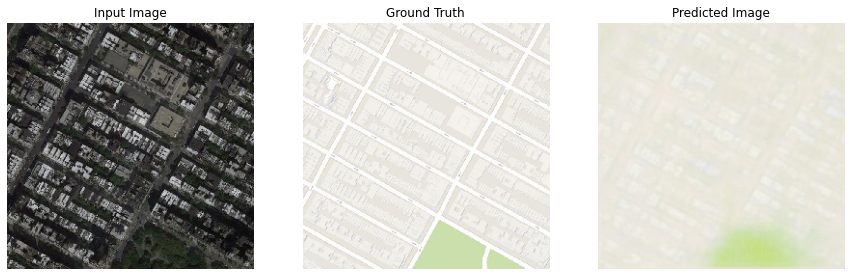

>7, 1/34, d1=4.427, d2=9.693 g=16.588
>7, 2/34, d1=4.670, d2=9.886 g=12.171
>7, 3/34, d1=4.878, d2=9.884 g=13.835
>7, 4/34, d1=4.814, d2=9.826 g=8.994
>7, 5/34, d1=4.783, d2=9.880 g=13.827
>7, 6/34, d1=3.865, d2=10.297 g=13.322
>7, 7/34, d1=4.019, d2=10.269 g=12.582
>7, 8/34, d1=4.582, d2=9.997 g=13.820
>7, 9/34, d1=4.418, d2=10.204 g=11.722
>7, 10/34, d1=3.938, d2=10.517 g=8.289
>7, 11/34, d1=4.476, d2=10.073 g=11.014
>7, 12/34, d1=4.755, d2=9.941 g=11.090
>7, 13/34, d1=3.705, d2=10.195 g=11.284
>7, 14/34, d1=4.605, d2=10.135 g=13.808
>7, 15/34, d1=4.607, d2=10.103 g=14.036
>7, 16/34, d1=5.136, d2=9.788 g=7.891
>7, 17/34, d1=4.606, d2=9.925 g=13.400
>7, 18/34, d1=4.392, d2=9.979 g=7.584
>7, 19/34, d1=7.690, d2=8.238 g=16.959
>7, 20/34, d1=3.575, d2=10.434 g=14.119
>7, 21/34, d1=4.039, d2=10.651 g=13.280
>7, 22/34, d1=5.118, d2=9.615 g=9.440
>7, 23/34, d1=4.509, d2=10.252 g=11.779
>7, 24/34, d1=4.811, d2=11.299 g=13.832
>7, 25/34, d1=4.229, d2=10.416 g=13.963
>7, 26/34, d1=5.346, d2=9.

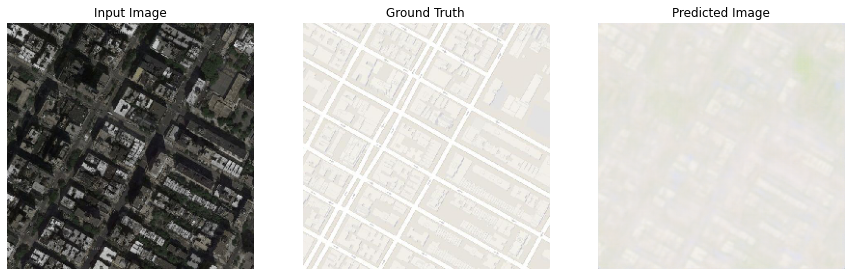

>8, 1/34, d1=7.839, d2=7.313 g=16.442
>8, 2/34, d1=6.348, d2=8.619 g=17.091
>8, 3/34, d1=6.709, d2=8.401 g=18.326
>8, 4/34, d1=6.430, d2=8.616 g=15.350
>8, 5/34, d1=9.070, d2=7.288 g=17.983
>8, 6/34, d1=8.211, d2=7.206 g=14.276
>8, 7/34, d1=6.848, d2=8.255 g=13.547
>8, 8/34, d1=7.357, d2=7.855 g=16.217
>8, 9/34, d1=7.089, d2=7.925 g=14.945
>8, 10/34, d1=6.368, d2=8.646 g=14.846
>8, 11/34, d1=8.010, d2=6.841 g=23.962
>8, 12/34, d1=6.965, d2=8.131 g=18.936
>8, 13/34, d1=7.860, d2=7.476 g=17.483
>8, 14/34, d1=6.937, d2=7.924 g=12.563
>8, 15/34, d1=7.618, d2=7.771 g=18.272
>8, 16/34, d1=7.692, d2=7.873 g=15.290
>8, 17/34, d1=8.371, d2=7.221 g=16.328
>8, 18/34, d1=6.416, d2=8.525 g=20.330
>8, 19/34, d1=8.009, d2=6.821 g=16.288
>8, 20/34, d1=6.433, d2=8.550 g=22.953
>8, 21/34, d1=8.886, d2=6.692 g=15.470
>8, 22/34, d1=6.332, d2=8.761 g=16.786
>8, 23/34, d1=6.027, d2=8.931 g=15.096
>8, 24/34, d1=7.207, d2=8.000 g=13.762
>8, 25/34, d1=8.277, d2=7.205 g=17.793
>8, 26/34, d1=8.914, d2=6.824 g=21

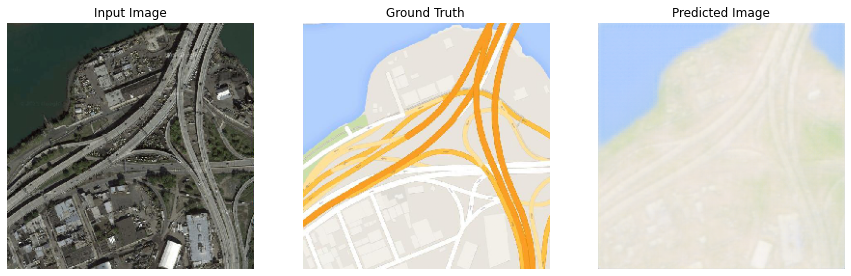

>9, 1/34, d1=0.519, d2=12.459 g=11.092
>9, 2/34, d1=1.948, d2=12.161 g=11.282
>9, 3/34, d1=1.546, d2=12.673 g=9.074
>9, 4/34, d1=0.878, d2=13.056 g=8.890
>9, 5/34, d1=1.500, d2=12.567 g=11.151
>9, 6/34, d1=0.946, d2=13.031 g=15.004
>9, 7/34, d1=1.642, d2=12.444 g=11.724
>9, 8/34, d1=0.968, d2=13.158 g=11.332
>9, 9/34, d1=0.982, d2=12.913 g=10.492
>9, 10/34, d1=1.244, d2=12.637 g=11.035
>9, 11/34, d1=0.484, d2=13.032 g=10.722
>9, 12/34, d1=1.164, d2=12.621 g=8.152
>9, 13/34, d1=0.210, d2=13.609 g=12.411
>9, 14/34, d1=1.587, d2=12.432 g=10.574
>9, 15/34, d1=0.557, d2=12.968 g=9.942
>9, 16/34, d1=1.584, d2=12.420 g=5.453
>9, 17/34, d1=0.565, d2=13.262 g=11.882
>9, 18/34, d1=0.707, d2=12.995 g=8.767
>9, 19/34, d1=1.470, d2=12.489 g=10.026
>9, 20/34, d1=1.619, d2=12.416 g=9.370
>9, 21/34, d1=1.500, d2=12.350 g=8.549
>9, 22/34, d1=1.355, d2=12.647 g=11.037
>9, 23/34, d1=1.294, d2=12.733 g=6.030
>9, 24/34, d1=1.316, d2=12.565 g=6.193
>9, 25/34, d1=1.156, d2=12.714 g=10.056
>9, 26/34, d1=0.848

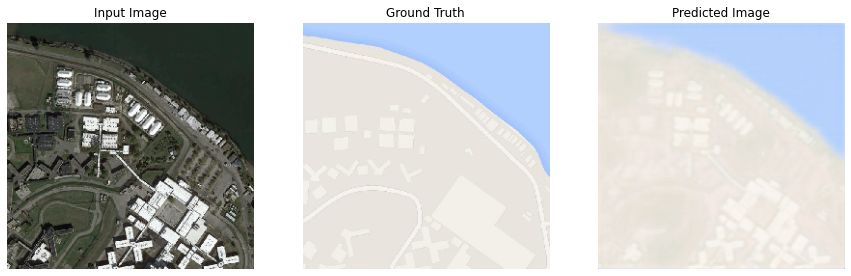

>10, 1/34, d1=2.081, d2=11.861 g=6.746
>10, 2/34, d1=2.169, d2=11.883 g=16.967
>10, 3/34, d1=1.808, d2=12.202 g=14.110
>10, 4/34, d1=0.624, d2=12.633 g=12.939
>10, 5/34, d1=2.937, d2=11.831 g=10.541
>10, 6/34, d1=2.205, d2=11.899 g=12.918
>10, 7/34, d1=1.956, d2=11.964 g=7.558
>10, 8/34, d1=0.937, d2=12.525 g=12.174
>10, 9/34, d1=1.377, d2=12.499 g=9.434
>10, 10/34, d1=2.361, d2=11.734 g=13.399
>10, 11/34, d1=1.706, d2=12.174 g=14.030
>10, 12/34, d1=1.751, d2=12.448 g=21.366
>10, 13/34, d1=2.151, d2=11.936 g=9.088
>10, 14/34, d1=1.472, d2=12.344 g=9.274
>10, 15/34, d1=1.781, d2=12.192 g=6.093
>10, 16/34, d1=1.696, d2=12.342 g=11.796
>10, 17/34, d1=1.631, d2=12.356 g=12.311
>10, 18/34, d1=1.461, d2=12.560 g=8.612
>10, 19/34, d1=2.080, d2=11.959 g=8.532
>10, 20/34, d1=0.535, d2=13.043 g=12.074
>10, 21/34, d1=1.519, d2=12.573 g=10.559
>10, 22/34, d1=0.686, d2=12.680 g=8.428
>10, 23/34, d1=1.245, d2=11.859 g=8.919
>10, 24/34, d1=1.416, d2=12.480 g=11.026
>10, 25/34, d1=2.858, d2=11.379 g=1

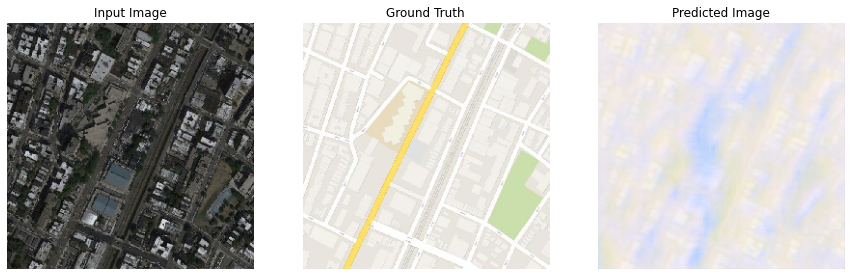

>11, 1/34, d1=2.509, d2=11.710 g=12.710
>11, 2/34, d1=2.352, d2=11.822 g=11.421
>11, 3/34, d1=0.688, d2=13.228 g=15.643
>11, 4/34, d1=2.539, d2=11.649 g=9.196
>11, 5/34, d1=2.618, d2=11.625 g=9.363
>11, 6/34, d1=2.407, d2=11.967 g=13.486
>11, 7/34, d1=2.065, d2=12.189 g=10.931
>11, 8/34, d1=2.514, d2=11.669 g=8.630
>11, 9/34, d1=2.676, d2=11.669 g=12.118
>11, 10/34, d1=2.765, d2=11.589 g=12.672
>11, 11/34, d1=2.460, d2=11.659 g=8.411
>11, 12/34, d1=2.782, d2=11.346 g=9.097
>11, 13/34, d1=2.509, d2=11.708 g=9.633
>11, 14/34, d1=2.424, d2=11.860 g=9.542
>11, 15/34, d1=2.478, d2=11.683 g=9.359
>11, 16/34, d1=1.684, d2=12.282 g=8.265
>11, 17/34, d1=2.325, d2=11.909 g=11.620
>11, 18/34, d1=1.853, d2=12.751 g=11.055
>11, 19/34, d1=1.634, d2=12.420 g=11.431
>11, 20/34, d1=1.891, d2=12.242 g=18.311
>11, 21/34, d1=2.119, d2=11.695 g=8.818
>11, 22/34, d1=2.651, d2=11.657 g=10.558
>11, 23/34, d1=1.392, d2=12.670 g=7.231
>11, 24/34, d1=1.528, d2=12.406 g=9.420
>11, 25/34, d1=2.233, d2=11.934 g=12.

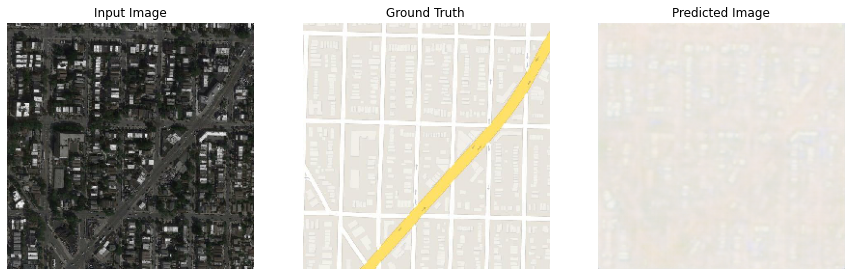

>12, 1/34, d1=3.645, d2=10.880 g=13.527
>12, 2/34, d1=3.551, d2=10.962 g=10.955
>12, 3/34, d1=3.809, d2=10.769 g=12.573
>12, 4/34, d1=3.725, d2=10.772 g=18.897
>12, 5/34, d1=4.237, d2=10.390 g=11.717
>12, 6/34, d1=3.755, d2=10.759 g=12.445
>12, 7/34, d1=4.350, d2=10.283 g=12.881
>12, 8/34, d1=3.674, d2=10.856 g=12.137
>12, 9/34, d1=4.525, d2=10.162 g=16.358
>12, 10/34, d1=4.031, d2=10.473 g=8.303
>12, 11/34, d1=3.859, d2=10.677 g=8.762
>12, 12/34, d1=3.352, d2=11.096 g=11.892
>12, 13/34, d1=4.670, d2=10.009 g=17.262
>12, 14/34, d1=4.698, d2=10.525 g=7.903
>12, 15/34, d1=3.604, d2=10.697 g=9.822
>12, 16/34, d1=4.159, d2=10.417 g=14.709
>12, 17/34, d1=3.147, d2=11.210 g=10.170
>12, 18/34, d1=3.922, d2=11.429 g=13.248
>12, 19/34, d1=4.377, d2=10.419 g=20.285
>12, 20/34, d1=1.766, d2=12.218 g=14.685
>12, 21/34, d1=4.108, d2=10.514 g=10.335
>12, 22/34, d1=4.015, d2=10.512 g=8.568
>12, 23/34, d1=3.809, d2=10.705 g=10.476
>12, 24/34, d1=3.883, d2=10.741 g=9.926
>12, 25/34, d1=3.713, d2=10.679

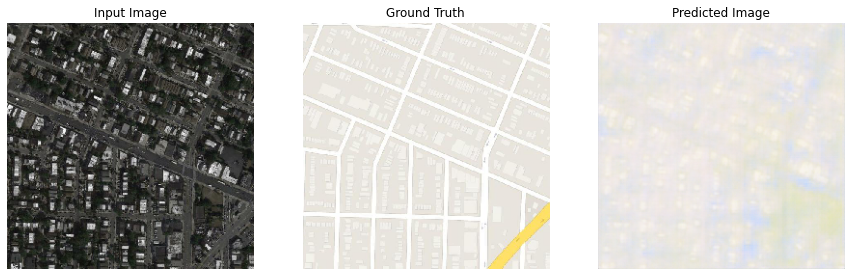

>13, 1/34, d1=1.152, d2=12.954 g=11.826
>13, 2/34, d1=2.064, d2=12.162 g=14.531
>13, 3/34, d1=1.322, d2=12.444 g=7.601
>13, 4/34, d1=1.722, d2=12.381 g=8.263
>13, 5/34, d1=1.963, d2=12.177 g=14.135
>13, 6/34, d1=1.345, d2=12.392 g=12.238
>13, 7/34, d1=2.728, d2=11.604 g=11.832
>13, 8/34, d1=1.686, d2=12.383 g=11.323
>13, 9/34, d1=1.748, d2=12.621 g=10.236
>13, 10/34, d1=2.183, d2=12.230 g=10.059
>13, 11/34, d1=2.080, d2=12.309 g=8.324
>13, 12/34, d1=0.206, d2=11.565 g=12.373
>13, 13/34, d1=0.069, d2=11.687 g=22.514
>13, 14/34, d1=1.824, d2=12.275 g=11.430
>13, 15/34, d1=2.329, d2=12.124 g=11.782
>13, 16/34, d1=2.097, d2=12.191 g=9.526
>13, 17/34, d1=0.637, d2=11.583 g=11.665
>13, 18/34, d1=2.248, d2=12.013 g=8.851
>13, 19/34, d1=2.011, d2=12.064 g=15.920
>13, 20/34, d1=2.337, d2=11.859 g=8.831
>13, 21/34, d1=2.112, d2=12.117 g=9.200
>13, 22/34, d1=1.063, d2=12.954 g=10.854
>13, 23/34, d1=1.277, d2=12.749 g=9.897
>13, 24/34, d1=1.839, d2=12.239 g=9.344
>13, 25/34, d1=1.528, d2=12.709 g=

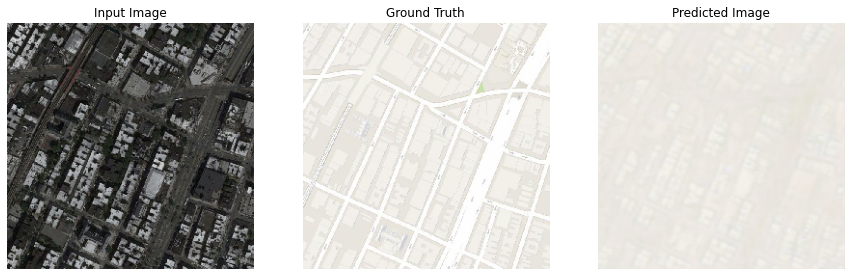

>14, 1/34, d1=1.927, d2=12.491 g=8.601
>14, 2/34, d1=1.973, d2=12.042 g=10.192
>14, 3/34, d1=2.161, d2=12.039 g=8.942
>14, 4/34, d1=2.424, d2=11.812 g=9.084
>14, 5/34, d1=2.391, d2=11.724 g=14.375
>14, 6/34, d1=2.137, d2=12.063 g=11.636
>14, 7/34, d1=1.355, d2=12.642 g=10.156
>14, 8/34, d1=1.372, d2=12.628 g=9.901
>14, 9/34, d1=1.700, d2=12.024 g=9.597
>14, 10/34, d1=1.736, d2=12.422 g=9.679
>14, 11/34, d1=2.116, d2=11.987 g=9.734
>14, 12/34, d1=2.082, d2=12.106 g=10.493
>14, 13/34, d1=1.509, d2=12.573 g=10.872
>14, 14/34, d1=1.578, d2=12.683 g=9.129
>14, 15/34, d1=2.047, d2=12.045 g=9.349
>14, 16/34, d1=1.820, d2=11.981 g=17.843
>14, 17/34, d1=2.196, d2=12.014 g=19.719
>14, 18/34, d1=1.514, d2=12.527 g=13.321
>14, 19/34, d1=1.699, d2=12.028 g=9.427
>14, 20/34, d1=2.644, d2=11.636 g=11.224
>14, 21/34, d1=1.994, d2=12.163 g=5.079
>14, 22/34, d1=2.115, d2=12.011 g=12.978
>14, 23/34, d1=1.972, d2=12.188 g=8.673
>14, 24/34, d1=1.855, d2=12.258 g=11.883
>14, 25/34, d1=2.177, d2=12.049 g=11.

In [ ]:
for i in range(150):
		# enumerate batches over the training set
  for j in range(1096):
    # get randomly selected 'real' samples

    ix = randint(0, 1096, 1)
    # select images and labels
    X_realA, X_realB = src_images[ix], tar_images[ix]

    # generate class labels
    y_real = ones((1, 30, 30, 1))

    # update discriminator model weights

    discriminator.trainable = True
    d_loss1 = discriminator.train_on_batch([X_realA, X_realB], y_real)
    # generate 'fake' examples



    X_fakeB = generator.predict(X_realA)
    # create class labels
    y_fake = zeros((1, 30, 30, 1))+0.1


    # update discriminator model weights
    d_loss2 = discriminator.train_on_batch([X_realA, X_fakeB], y_fake)
    # prepare points in latent space as input for the generator

    discriminator.trainable = False

    ix = randint(0, 1096, 2)
    X_realA, X_realB = src_images[ix], tar_images[ix]
    y_real = ones((2, 30, 30, 1))
    # update the generator via the discriminator's error
    g_loss, _, _ = gan.train_on_batch(X_realA, [y_real, X_realB])
    # summarize loss on this batch
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, 1096//32, d_loss1, d_loss2, g_loss))
  ix = randint(0, 1096, 1)
  generate_images(generator, src_images[ix], tar_images[ix])
  if i%5==0 :
    generator.save('drive/My Drive/Pix2pix/maps/generator.h5')

# save the generator model

In [ ]:
generator.save('model.h5')

In [6]:
import numpy
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

In [7]:
generator = load_model('drive/My Drive/Pix2pix/maps/generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
path = '/content/drive/My Drive/Pix2pix/maps/val/'

src_list, tar_list = list(), list()
i=0
for filename in listdir(path):
  if (filename.endswith(".jpg")):
    pixels = load_img(path + filename, target_size=(256,512))
    pixels = img_to_array(pixels)
    sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
    if(i==3) :
      break
    i+=1
src_images = asarray(src_list)
tar_images = asarray(tar_list)

print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (4, 256, 256, 3) (4, 256, 256, 3)


In [13]:
src_images = (src_images - 127.5) / 127.5
tar_images = (tar_images - 127.5) / 127.5

In [14]:
import numpy

In [15]:
X  = generator.predict(numpy.expand_dims(src_images[1], axis=0))
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

In [16]:
from matplotlib import pyplot

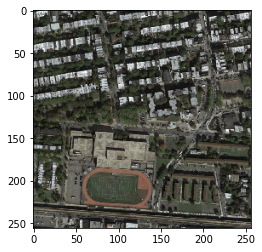

In [17]:
pyplot.imshow((src_images[1]+1)/2.0)

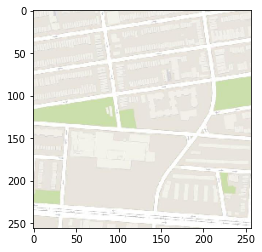

In [18]:
pyplot.imshow((tar_images[1]+1)/2.0)

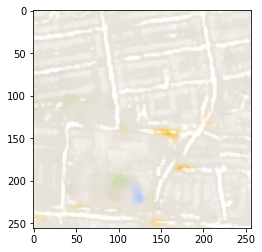

In [19]:
pyplot.imshow(X.reshape(256,256,3))